In [13]:
!pip install -q opencv-python opencv-contrib-python numpy matplotlib scikit-image pandas

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import exposure, filters, feature, color, img_as_float
import skimage
import pathlib, warnings, platform, os
warnings.filterwarnings('ignore')

print("✅ Librerías listas")
print(f"OpenCV: {cv2.__version__}")
print(f"scikit-image: {skimage.__version__}")
print(f"Python: {platform.python_version()}")

✅ Librerías listas
OpenCV: 4.12.0
scikit-image: 0.25.2
Python: 3.13.5


In [14]:
from skimage import data as skdata, io as skio

RAW_DIR = pathlib.Path("data/raw")
RAW_DIR.mkdir(parents=True, exist_ok=True)

samples_sk = {
    "camera.png": skdata.camera(),
    "astronaut.png": skdata.astronaut(),
    "coffee.png": skdata.coffee(),
    "coins.png": skdata.coins(),
    "checkerboard.png": skdata.checkerboard(),
    "rocket.png": skdata.rocket(),
    "page.png": skdata.page()
}

for name, img in samples_sk.items():
    out = RAW_DIR / name
    skio.imsave(out.as_posix(), img)

print("✅ Pack mínimo descargado en", RAW_DIR)

✅ Pack mínimo descargado en data\raw


In [24]:
DATA_DIR = pathlib.Path("data/raw")
SAMPLES_DIR = pathlib.Path("data/samples")
OUTPUTS = {
    "preproc": pathlib.Path("outputs/preproc"),
    "features": pathlib.Path("outputs/features"),
    "metrics": pathlib.Path("outputs/metrics"),
}
for p in OUTPUTS.values():
    p.mkdir(parents=True, exist_ok=True)

# Crear carpeta para imágenes del reporte
IMG_DIR = pathlib.Path("img")
IMG_DIR.mkdir(parents=True, exist_ok=True)

images = sorted([p for p in DATA_DIR.glob("**/*")
                 if p.suffix.lower() in {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}])
print("Imágenes encontradas:", len(images))
images[:5]

Imágenes encontradas: 7


[WindowsPath('data/raw/astronaut.png'),
 WindowsPath('data/raw/camera.png'),
 WindowsPath('data/raw/checkerboard.png'),
 WindowsPath('data/raw/coffee.png'),
 WindowsPath('data/raw/coins.png')]

In [16]:
from pathlib import Path

def read_image_bgr(path: Path):
    img_bgr = cv2.imread(str(path), cv2.IMREAD_COLOR)
    assert img_bgr is not None, f"No se pudo leer: {path}"
    return img_bgr

img_path = images[0]
img_bgr = read_image_bgr(img_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

height, width = img_gray.shape[:2]
channels = img_rgb.shape[2] if img_rgb.ndim == 3 else 1
dtype = img_bgr.dtype
min_val, max_val = int(img_gray.min()), int(img_gray.max())
mean_gray = float(img_gray.mean())

print("H, W, C:", height, width, channels)
print("dtype:", dtype, "rango:", (min_val, max_val), "mean_gray:", round(mean_gray, 2))

H, W, C: 512 512 3
dtype: uint8 rango: (0, 255) mean_gray: 115.41


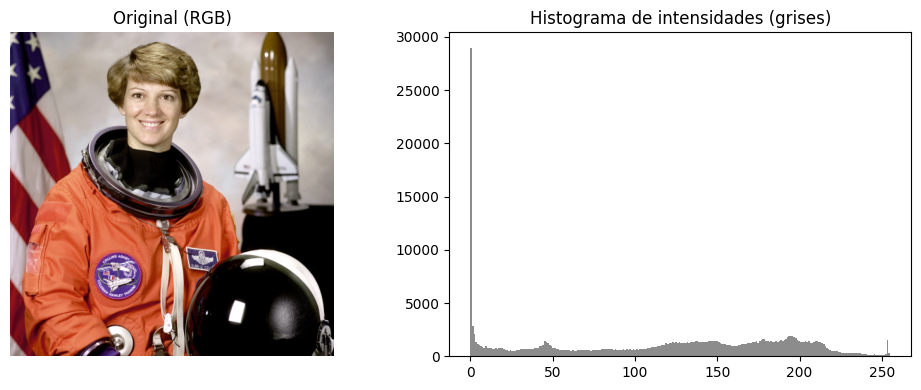

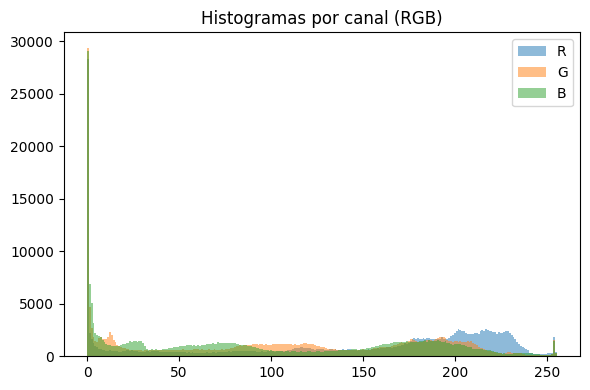

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(img_rgb); axes[0].set_title("Original (RGB)"); axes[0].axis("off")

axes[1].hist(img_gray.ravel(), bins=256, range=(0, 255), color="gray", alpha=0.9)
axes[1].set_title("Histograma de intensidades (grises)")
plt.tight_layout()
plt.savefig("img/01_original_e_histograma.png", dpi=150, bbox_inches='tight')
plt.show()

# Si es color: histogramas por canal
colors = ("R", "G", "B")
plt.figure(figsize=(6,4))
for i, c in enumerate(colors):
    plt.hist(img_rgb[..., i].ravel(), bins=256, range=(0, 255), alpha=0.5, label=c)
plt.legend(); plt.title("Histogramas por canal (RGB)")
plt.tight_layout()
plt.savefig("img/02_histogramas_rgb.png", dpi=150, bbox_inches='tight')
plt.show()

Preguntas de reflexión — Parte A (completa los espacios)¶

1) El rango dinámico observado fue de 0 a 255. Esto sugiere que la imagen utiliza todo el rango posible de intensidades. Es decir, tiene buena amplitud tonal y no presenta recortes ni en sombras ni en luz.

2) El histograma indica medio a alto contraste porque los valores de intensidad estan distribuidos a lo largo de casi todo el rango, con picos tanto en zonas oscuras (0-50), como en tonos medios y claros (150-230), mostrando presencia de sombras y brillos bien definidos.

3) En color, el canal con mayor dominancia fue R (rojo); implicancia: la imagen tiene un tinte cálido general, coherente con el traje naranja del astronauta y la iluminación de tonos rojizos predominantes.

Pistas: - Rango típico en 8‑bit: 0–255; bajo contraste = histograma estrecho alrededor de la media. - Dominancia de canal: tintes de color (p. ej., rojo dominante en interiores cálidos).



In [18]:
img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
img_lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)

salient_hsv_channel = "H"  # "H" | "S" | "V"
salient_lab_channel = "L"  # "L" | "A" | "B"
print("Canales relevantes:", salient_hsv_channel, salient_lab_channel)

Canales relevantes: H L


STD contraste — before/eq/clahe: 75.12 80.25 76.51


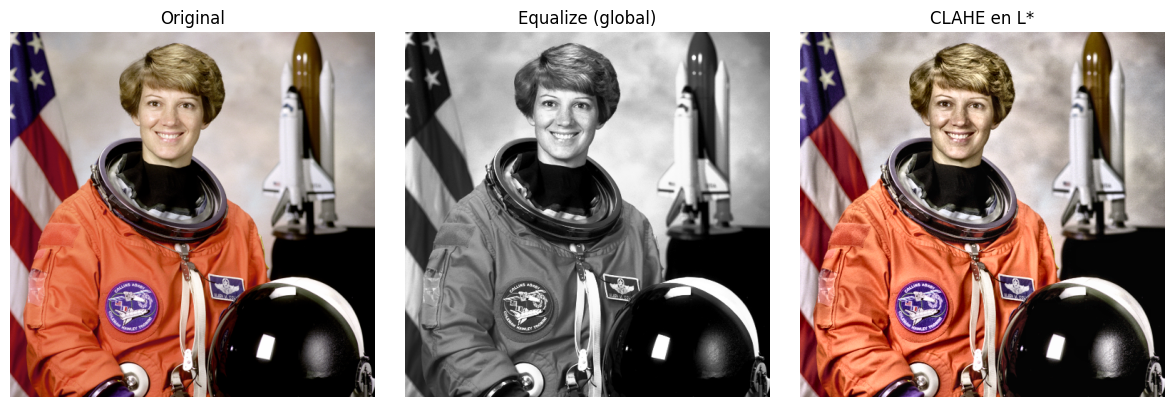

In [26]:
# Global en grises
eq_gray = cv2.equalizeHist(img_gray)

# CLAHE en L* (LAB)
L, A, B = cv2.split(img_lab)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(15, 25))
L_clahe = clahe.apply(L)
lab_clahe = cv2.merge([L_clahe, A, B])
rgb_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)

def contrast_std(x: np.ndarray) -> float:
    return float(np.std(x.astype(np.float32)))

std_before = contrast_std(img_gray)
std_eq = contrast_std(eq_gray)
std_clahe = contrast_std(cv2.cvtColor(rgb_clahe, cv2.COLOR_RGB2GRAY))
print("STD contraste — before/eq/clahe:", round(std_before,2), round(std_eq,2), round(std_clahe,2))

fig, axes = plt.subplots(1, 3, figsize=(12,4))
axes[0].imshow(img_rgb); axes[0].set_title("Original"); axes[0].axis("off")
axes[1].imshow(eq_gray, cmap="gray"); axes[1].set_title("Equalize (global)"); axes[1].axis("off")
axes[2].imshow(rgb_clahe); axes[2].set_title("CLAHE en L*"); axes[2].axis("off")
plt.tight_layout()
plt.savefig("img/03_ecualizacion_clahe.png", dpi=150, bbox_inches='tight')
plt.show()

Preguntas de reflexión — Parte B (completa los espacios)¶

1) El canal más informativo (HSV/LAB) fue L (en LAB) porque representa la luminancia, es decir, la información de brillo independiente del color, lo que permite mejorar el contraste sin alterar los tonos originales.

2) CLAHE mejoró menos que la ecualización global en zonas homogéneas porque ajusta el contraste de manera local y limitada (clipLimit), evitando la sobreexpansión del histograma y preservando las texturas suaves sin generar saturaciones ni ruido.

3) El cambio en la desviación estándar sugiere un aumento moderado del contraste global, ya que la STD pasó de 75.12 a 80.25 con la ecualización global y a 76.51 con CLAHE, indicando que ambos métodos amplían la dispersión de intensidades, pero CLAHE lo hace de forma más controlada.


In [20]:
gaussian = cv2.GaussianBlur(img_gray, ksize=(3, 3), sigmaX=1.5)
bilateral = cv2.bilateralFilter(img_gray, d=9, sigmaColor=75, sigmaSpace=75)

def grad_variance(x: np.ndarray) -> float:
    gx = cv2.Sobel(x, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(x, cv2.CV_32F, 0, 1, ksize=3)
    g = np.hypot(gx, gy)
    return float(np.var(g))

gv_before = grad_variance(img_gray)
gv_gauss = grad_variance(gaussian)
gv_bilat = grad_variance(bilateral)
print("Var(grad) — before/gauss/bilateral:", round(gv_before,2), round(gv_gauss,2), round(gv_bilat,2))

Var(grad) — before/gauss/bilateral: 10788.16 6351.84 5488.11


Edges ratio — before/gauss/bilateral: 0.102 0.077 0.077


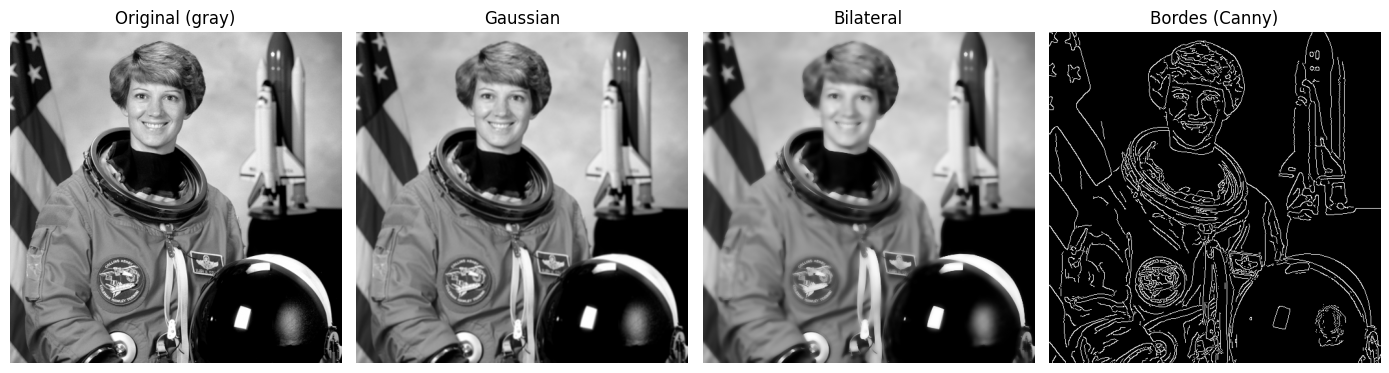

In [27]:
edges_before = cv2.Canny(img_gray, threshold1=50, threshold2=150)
edges_gauss = cv2.Canny(gaussian, threshold1=50, threshold2=150)
edges_bilat = cv2.Canny(bilateral, threshold1=25, threshold2=55)

def edge_ratio(x: np.ndarray) -> float:
    return float((x > 0).mean())

er_before = edge_ratio(edges_before)
er_gauss = edge_ratio(edges_gauss)
er_bilat = edge_ratio(edges_bilat)
print("Edges ratio — before/gauss/bilateral:", round(er_before,3), round(er_gauss,3), round(er_bilat,3))

fig, axes = plt.subplots(1, 4, figsize=(14,4))
axes[0].imshow(img_gray, cmap="gray"); axes[0].set_title("Original (gray)"); axes[0].axis("off")
axes[1].imshow(gaussian, cmap="gray"); axes[1].set_title("Gaussian"); axes[1].axis("off")
axes[2].imshow(bilateral, cmap="gray"); axes[2].set_title("Bilateral"); axes[2].axis("off")
axes[3].imshow(edges_bilat, cmap="gray"); axes[3].set_title("Bordes (Canny)"); axes[3].axis("off")
plt.tight_layout()
plt.savefig("img/04_filtros_y_bordes.png", dpi=150, bbox_inches='tight')
plt.show()

Preguntas de reflexión — Parte C (completa los espacios)¶

1) El suavizado que mejor conservó bordes fue el bilateral, porque reduce el ruido y las texturas suaves sin difuminar los contornos principales, ya que combina filtrado espacial con diferencia de intensidad, preservando las transiciones fuertes.

2) El ratio de bordes sugiere ruido en la variante original, porque tiene el valor más alto (0.102), lo que indica detección de muchos gradientes débiles o falsos bordes que fueron eliminados tras el suavizado.

3) Cambiarías los thresholds de Canny a (bajos, por ejemplo 20 y 50) para escenas nocturnas porque en condiciones de poca luz los contrastes son menores, y se necesita una detección más sensible para captar bordes débiles que de otro modo quedarían descartados.

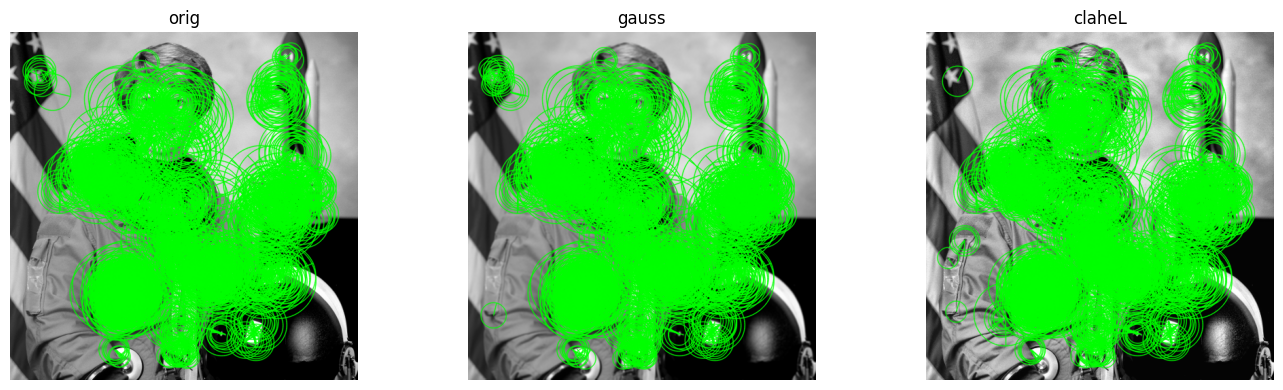

In [28]:
variants = {
    "orig": img_gray,
    "gauss": gaussian,
    "claheL": cv2.cvtColor(rgb_clahe, cv2.COLOR_RGB2GRAY)
}

# ORB (rápido, binario)
orb = cv2.ORB_create(nfeatures=1500, scaleFactor=1.2, nlevels=8)

kp_stats = []
overlay_examples = []
for name, img in variants.items():
    kp, des = orb.detectAndCompute(img, None)
    kp_stats.append({"variant": name, "num_keypoints": len(kp), "descriptor_size": 0 if des is None else des.shape[1]})
    out = cv2.drawKeypoints(img, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS, color=(0,255,0))
    overlay_examples.append((name, out))

pd.DataFrame(kp_stats)
fig, axes = plt.subplots(1, len(overlay_examples), figsize=(14,4))
for ax, (name, out) in zip(axes, overlay_examples):
    ax.imshow(out, cmap="gray"); ax.set_title(name); ax.axis("off")
plt.tight_layout()
plt.savefig("img/05_keypoints_orb.png", dpi=150, bbox_inches='tight')
plt.show()

#kp_orig: 1500 #kp_claheL: 1500 matches: 856 ratio: 0.57


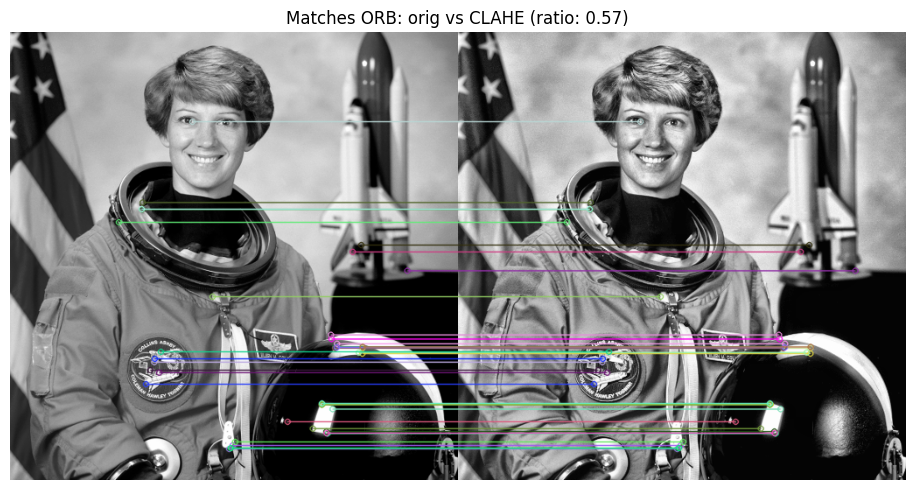

In [29]:
# Emparejar orig vs claheL con ORB
kp1, des1 = orb.detectAndCompute(variants["orig"], None)
kp2, des2 = orb.detectAndCompute(variants["claheL"], None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2) if (des1 is not None and des2 is not None) else []
matches = sorted(matches, key=lambda m: m.distance)

matches_ratio = (len(matches) / max(1, min(len(kp1), len(kp2)))) if (len(kp1) and len(kp2)) else 0.0
print("#kp_orig:", len(kp1), "#kp_claheL:", len(kp2), "matches:", len(matches), "ratio:", round(matches_ratio,2))

img_match = cv2.drawMatches(variants["orig"], kp1, variants["claheL"], kp2, matches[:40], None, flags=2)
plt.figure(figsize=(12,5))
plt.imshow(img_match, cmap="gray")
plt.axis("off")
plt.title(f"Matches ORB: orig vs CLAHE (ratio: {round(matches_ratio,2)})")
plt.tight_layout()
plt.savefig("img/06_matches_orb.png", dpi=150, bbox_inches='tight')
plt.show()

Preguntas de reflexión — Parte D (completa los espacios)¶

1) La variante con mayor densidad de keypoints fue CLAHE en L*; motivo probable: el aumento del micro-contraste local resalta bordes y texturas que ORB interpreta como puntos de interés, favoreciendo una distribución más uniforme y detallada de keypoints.

2) La repetibilidad (matches_ratio) aumentó con CLAHE, porque al mejorar la luminancia sin deformar la estructura geométrica, las características detectadas se mantienen más estables entre imágenes, generando más coincidencias válidas (≈ 0.57).

3) Cambiarías parámetros de ORB a (nfeatures = 1000, scaleFactor = 1.3) para equilibrar calidad y tiempo,
porque reducir la cantidad de puntos y aumentar ligeramente el factor de escala disminuye el costo computacional, manteniendo una detección suficiente para correspondencias robustas.

Preguntas de reflexión finales (completa los espacios)¶

1) La transformación más útil para tu dataset fue CLAHE en L* porque mejoró sin introducir el contraste local y la estabilidad de las features sin introducir saturaciones, ruido ni pérdida de color.

2) El canal más informativo (HSV/LAB) fue L (en LAB); lo usarías para operaciones de realce de brillo o contraste (ecualización, CLAHE, normalización) sin alterar los tonos de color originales.

3) El trade‑off más claro entre suavizado y features fue entre el filtrado bilateral y la detección ORB; criterio de selección: usar filtrado más fuerte (bilateral) cuando se prioriza eliminar ruido, y más débil (gaussiano o ninguno) cuando se busca conservar detalle para detección de puntos clave.

4) Checks automáticos que propondrías: umbrales para num_keypoints < 800, edges_ratio ∉ [0.05, 0.12], alerta por caída de contraste STD < 70.